In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('2024-01-02LOBs.csv')

In [3]:
df.tail()

,time,bid,ask
631671,30599.852,231.78,543.2
631672,30599.883,231.78,543.2
631673,30599.914,231.78,543.0
631674,30599.945,231.78,543.0
631675,30599.976,242.12,543.0


In [4]:
df.shape

(631676, 3)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score

In [6]:
df = df.drop(columns=['time'])

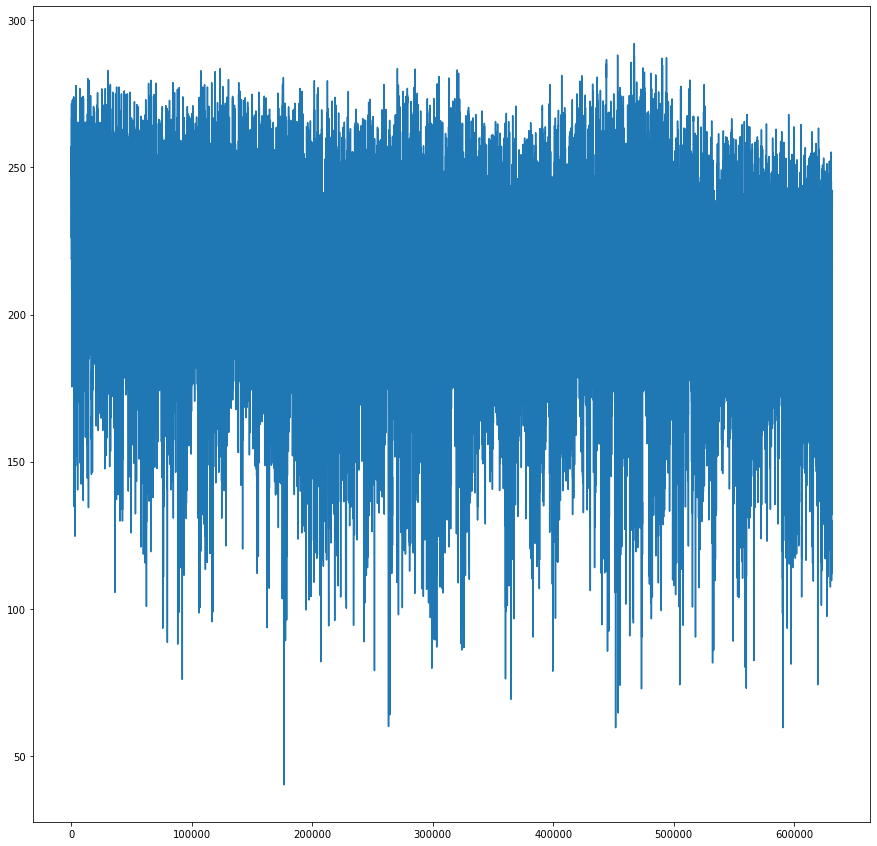

In [7]:
plt.figure(figsize=(15,15))
plt.plot(df['bid'])

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)   
bid_price = df[:,0]
ask_price = df[:,1]

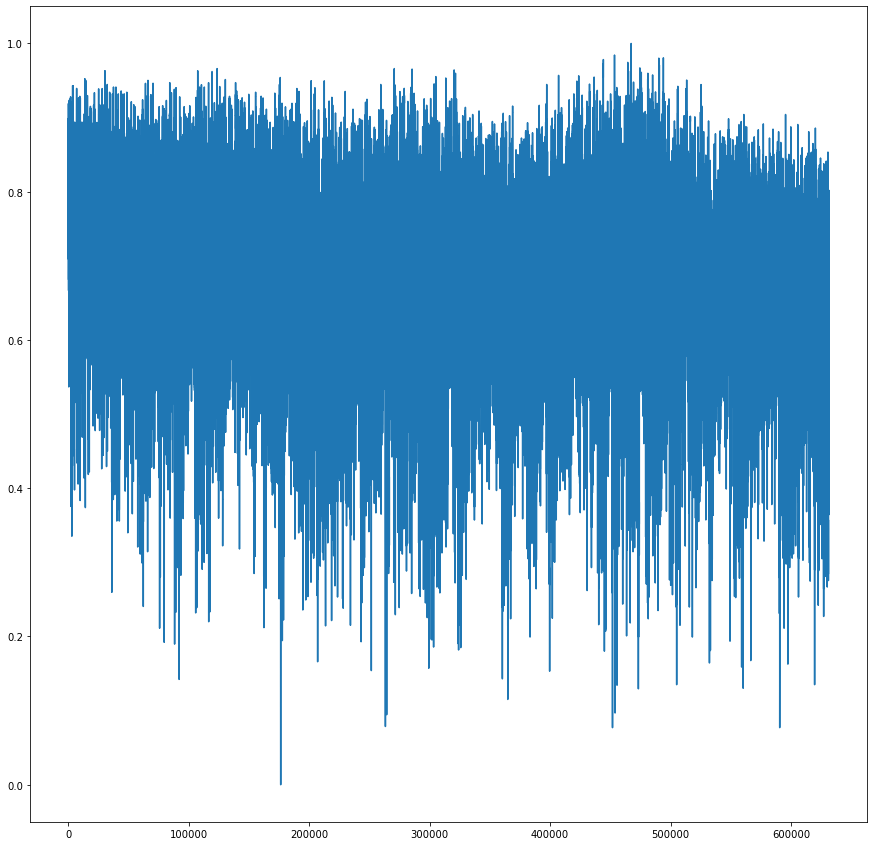

In [9]:
plt.figure(figsize=(15,15))
plt.plot(bid_price)
plt.show()

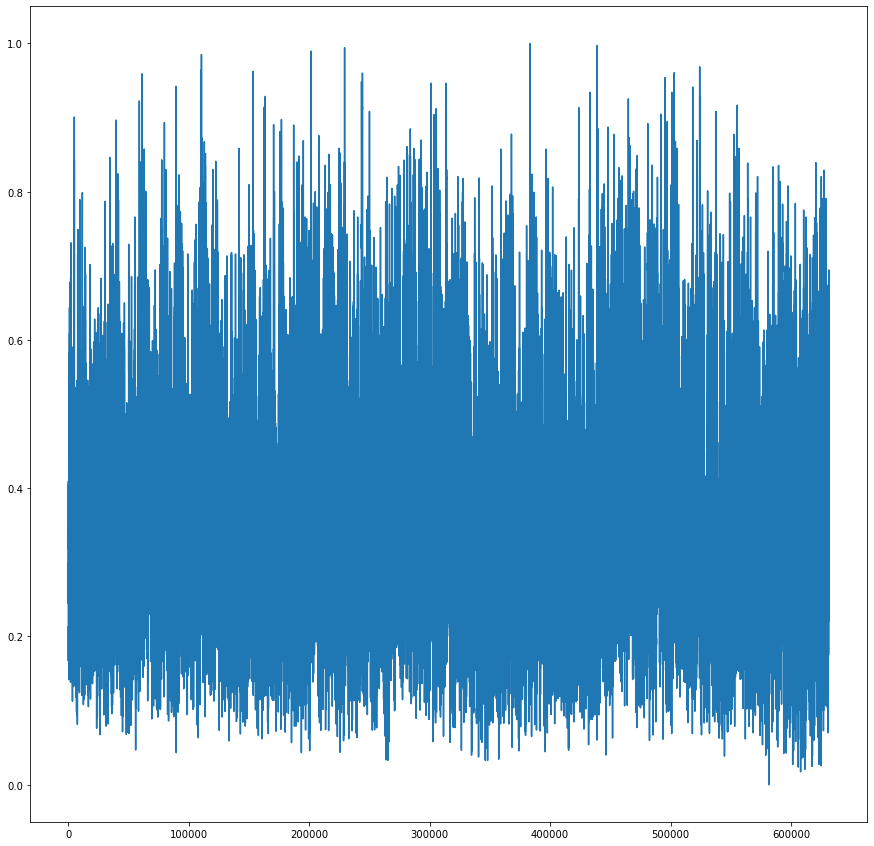

In [10]:
plt.figure(figsize=(15,15))
plt.plot(ask_price)
plt.show()

In [11]:
# split the train and test dataset
ntrain = int(len(bid_price)*0.8) 

train = df[0:ntrain]
test  = df[ntrain:len(df)]

bid_train = bid_price[0:ntrain]
bid_test  = bid_price[ntrain:len(bid_price)]

In [12]:
bid_test.shape

(126336,)

## construct the array to the image

In [13]:
def to_sequences(seq_size,data,bid):
    x = []
    y = []
    
    for i in range(len(data)-seq_size-1):
        window = data[i:i+seq_size]
        after_window = bid[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

timesteps = 10

x_train,y_train = to_sequences(timesteps, train, bid_train)
x_test,y_test = to_sequences(timesteps, test, bid_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (505329, 10, 1, 2)
Shape of x_test: (126325, 10, 1, 2)
Shape of y_train: (505329,)
Shape of y_test: (126325,)


In [14]:
x_train[0]

array([[[0.70969278, 0.21281997]],

       [[0.70969278, 0.21281997]],

       [[0.70969278, 0.21281997]],

       [[0.70969278, 0.21281997]],

       [[0.70969278, 0.21281997]],

       [[0.70969278, 0.21281997]],

       [[0.70969278, 0.21281997]],

       [[0.70969278, 0.21281997]],

       [[0.70969278, 0.19145335]],

       [[0.70969278, 0.19145335]]])

In [15]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[2], x_train.shape[1],x_train.shape[3]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[2],x_test.shape[1],x_test.shape[3]))

In [16]:
print(x_train.shape)

(505329, 1, 10, 2)


In [17]:
x_train[0][0].shape

(10, 2)

## plot the image

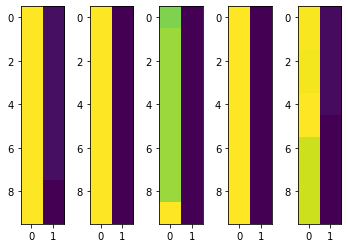

In [18]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.imshow(x_train[0][0])
ax2.imshow(x_train[10][0])
ax3.imshow(x_train[20][0])
ax4.imshow(x_train[30][0])
ax5.imshow(x_train[40][0])

## CNN model

In [19]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
import csv
import collections
from scipy.stats import zscore
from datetime import datetime

In [20]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(1,2), strides = (1,1),
                padding = 'valid', activation='relu', input_shape = (1,10,2)))
model.add(MaxPooling2D(pool_size=(1,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 9, 8)           40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 4, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [21]:
model.compile(loss='mean_squared_error', optimizer='nadam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1, patience=2, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='CNN_Patameters.hdf5',verbose=0, save_best_only=True)

In [22]:
# train model
model.fit(x_train,y_train,validation_split=0.2, batch_size=64,
         callbacks=[checkpointer], verbose=1, epochs=50)

Epoch 1/50
6317/6317 [==============================] - 9s 1ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 2/50
6317/6317 [==============================] - 7s 1ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 3/50
6317/6317 [==============================] - 7s 1ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 4/50
6317/6317 [==============================] - 8s 1ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/50
6317/6317 [==============================] - 7s 1ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 6/50
6317/6317 [==============================] - 8s 1ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/50
6317/6317 [==============================] - 8s 1ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/50
6317/6317 [==============================] - 8s 1ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/50
6317/6317 [==============================] - 7s 1ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/50
6317/6317 [==============================] - 7s 1ms/step - loss: 0.002

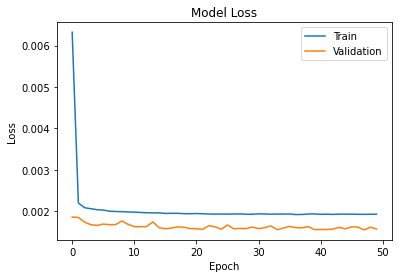

In [23]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [24]:
model.load_weights('CNN_Patameters.hdf5')

pred = model.predict(x_test)
print(pred.shape)

3948/3948 [==============================] - 2s 504us/step
(126325, 1)


In [25]:
np.shape(y_test)

(126325,)

In [26]:
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("RMSE Score: {}".format(score))

RMSE Score: 0.03572415504558519


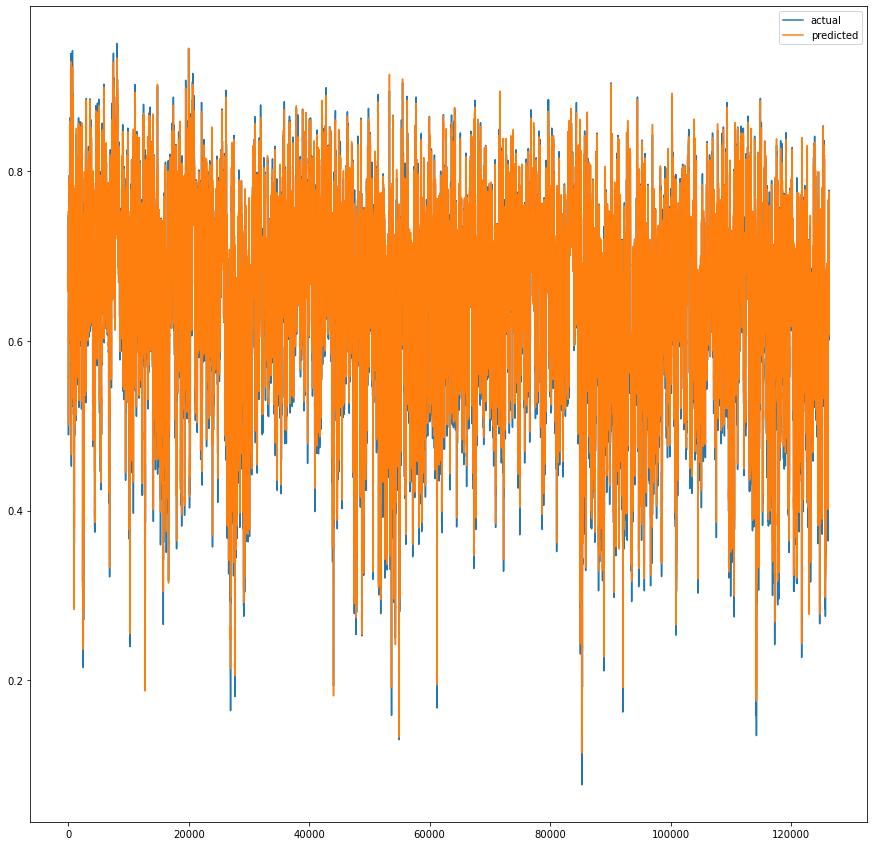

In [27]:
plt.figure(figsize=(15,15))

plt.plot(y_test, label = 'actual')
plt.plot(pred,   label = 'predicted')
plt.legend()
plt.show()